In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools
from itertools import combinations, chain
import time
import copy
import scipy.stats
from collections import defaultdict
import csv
import sys
import random

In [2]:
# Load all necessary data
ppi = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\PPI data 20_08_2020\\PPI with Uniprot IDs\\PPI.csv', encoding = 'utf-8', compression = 'gzip', low_memory = False, sep = '\t')
uniprot_ids = pd.read_csv(r'D:\\Jana De Coster\\Documents\\Ugent\\2de master\\Master thesis\\Network\\Data interaction network\\Metadata\\Filtered metadata\\Metadata.csv', encoding = 'utf-8', compression = 'gzip', low_memory = False, sep = '\t')
ppi2 = ppi.copy()
uniprot_ids = uniprot_ids.astype(str)

# DIAMOnD algorithm

**A DIseAse MOdule Detection (DIAMOnD) Algorithm Derived from a Systematic Analysis of Connectivity Patterns of Disease Proteins in the Human Interactome:**

Disease associated proteins do not reside within locally dense communities and instead identify connectivity significance as the most predictive quantity.
Disease Module Detection (DIAMOnD) algorithm to identify the full disease module around a set of known disease proteins.

Building on the observation that the connectivity significance is highly distinctive for known disease proteins, we propose the following algorithm to infer yet unknown disease proteins, and hence to identify the respective disease module:

* The connectivity significance is determined for all proteins connected to any of the s0 seed proteins.
* The proteins are ranked according to their respective p-values.
* The protein with the highest rank (i.e. lowest p-value) is added to the set of seed nodes, increasing their number from s0 →s1 = s0+1.
* Steps (i)-(iii) are repeated with the expanded set of seed proteins, pulling in one protein at a time into the growing disease module.

In [3]:
# https://github.com/dinaghiassian/DIAMOnD

# =============================================================================
print(' ')
print('        usage: python3 DIAMOnD.py network_file seed_file n alpha(optional) outfile_name (optional)')
print('        -----------------------------------------------------------------')
print('        network_file : The edgelist must be provided as any delimiter-separated')
print('                       table. Make sure the delimiter does not exit in gene IDs')
print('                       and is consistent across the file.')
print('                       The first two columns of the table will be')
print('                       interpreted as an interaction gene1 <==> gene2')
print('        seed_file    : table containing the seed genes (if table contains')
print('                       more than one column they must be tab-separated;')
print('                       the first column will be used only)')
print('        n            : desired number of DIAMOnD genes, 200 is a reasonable')
print('                       starting point.')
print('        alpha        : an integer representing weight of the seeds,default')
print('                       value is set to 1')
print('        outfile_name : results will be saved under this file name')
print('                       by default the outfile_name is set to "first_n_added_nodes_weight_alpha.txt"')
print(' ')


# =============================================================================

def read_input(network_file, seed_file):
    """
    Reads the network and the list of seed genes from external files.
    * The edgelist must be provided as a tab-separated table. The
    first two columns of the table will be interpreted as an
    interaction gene1 <==> gene2
    * The seed genes mus be provided as a table. If the table has more
    than one column, they must be tab-separated. The first column will
    be used only.
    * Lines that start with '#' will be ignored in both cases
    """

    sniffer = csv.Sniffer()
    line_delimiter = None
    for line in open(network_file, 'r'):
        if line[0] == '#':
            continue
        else:
            dialect = sniffer.sniff(line)
            line_delimiter = dialect.delimiter
            break
    if line_delimiter == None:
        print
        'network_file format not correct'
        sys.exit(0)

    # read the network:
    G = nx.Graph()
    for line in open(network_file, 'r'):
        # lines starting with '#' will be ignored
        if line[0] == '#':
            continue
        # The first two columns in the line will be interpreted as an
        # interaction gene1 <=> gene2
        # line_data   = line.strip().split('\t')
        line_data = line.strip().split(line_delimiter)
        node1 = line_data[0]
        node2 = line_data[1]
        G.add_edge(node1, node2)

    # read the seed genes:
    seed_genes = set()
    for line in open(seed_file, 'r'):
        # lines starting with '#' will be ignored
        if line[0] == '#':
            continue
        # the first column in the line will be interpreted as a seed
        # gene:
        line_data = line.strip().split('\t')
        seed_gene = line_data[0]
        seed_genes.add(seed_gene)

    return G, seed_genes


# ================================================================================
def compute_all_gamma_ln(N):
    """
    precomputes all logarithmic gammas
    """
    gamma_ln = {}
    for i in range(1, N + 1):
        gamma_ln[i] = scipy.special.gammaln(i)

    return gamma_ln


# =============================================================================
def logchoose(n, k, gamma_ln):
    if n - k + 1 <= 0:
        return scipy.infty
    lgn1 = gamma_ln[n + 1]
    lgk1 = gamma_ln[k + 1]
    lgnk1 = gamma_ln[n - k + 1]
    return lgn1 - [lgnk1 + lgk1]


# =============================================================================
def gauss_hypergeom(x, r, b, n, gamma_ln):
    return np.exp(logchoose(r, x, gamma_ln) +
                  logchoose(b, n - x, gamma_ln) -
                  logchoose(r + b, n, gamma_ln))


# =============================================================================
def pvalue(kb, k, N, s, gamma_ln):
    """
    -------------------------------------------------------------------
    Computes the p-value for a node that has kb out of k links to
    seeds, given that there's a total of s sees in a network of N nodes.
    p-val = \sum_{n=kb}^{k} HypergemetricPDF(n,k,N,s)
    -------------------------------------------------------------------
    """
    p = 0.0
    for n in range(kb, k + 1):
        if n > s:
            break
        prob = gauss_hypergeom(n, s, N - s, k, gamma_ln)
        # print prob
        p += prob

    if p > 1:
        return 1
    else:
        return p

    # =============================================================================


def get_neighbors_and_degrees(G):
    neighbors, all_degrees = {}, {}
    for node in G.nodes():
        nn = set(G.neighbors(node))
        neighbors[node] = nn
        all_degrees[node] = G.degree(node)

    return neighbors, all_degrees


# =============================================================================
# Reduce number of calculations
# =============================================================================
def reduce_not_in_cluster_nodes(all_degrees, neighbors, G, not_in_cluster, cluster_nodes, alpha):
    reduced_not_in_cluster = {}
    kb2k = defaultdict(dict)
    for node in not_in_cluster:

        k = all_degrees[node]
        kb = 0
        # Going through all neighbors and counting the number of module neighbors
        for neighbor in neighbors[node]:
            if neighbor in cluster_nodes:
                kb += 1

        # adding wights to the the edges connected to seeds
        k += (alpha - 1) * kb
        kb += (alpha - 1) * kb
        kb2k[kb][k] = node

    # Going to choose the node with largest kb, given k
    k2kb = defaultdict(dict)
    for kb, k2node in kb2k.items():
        min_k = min(k2node.keys())
        node = k2node[min_k]
        k2kb[min_k][kb] = node

    for k, kb2node in k2kb.items():
        max_kb = max(kb2node.keys())
        node = kb2node[max_kb]
        reduced_not_in_cluster[node] = (max_kb, k)

    return reduced_not_in_cluster


# ======================================================================================
#   C O R E    A L G O R I T H M
# ======================================================================================
def diamond_iteration_of_first_X_nodes(G, S, X, alpha):
    """
    Parameters:
    ----------
    - G:     graph
    - S:     seeds
    - X:     the number of iterations, i.e only the first X gened will be
             pulled in
    - alpha: seeds weight
    Returns:
    --------
    - added_nodes: ordered list of nodes in the order by which they
      are agglomerated. Each entry has 4 info:
      * name : dito
      * k    : degree of the node
      * kb   : number of +1 neighbors
      * p    : p-value at agglomeration
    """

    N = G.number_of_nodes()

    added_nodes = []

    # ------------------------------------------------------------------
    # Setting up dictionaries with all neighbor lists
    # and all degrees
    # ------------------------------------------------------------------
    neighbors, all_degrees = get_neighbors_and_degrees(G)

    # ------------------------------------------------------------------
    # Setting up initial set of nodes in cluster
    # ------------------------------------------------------------------

    cluster_nodes = set(S)
    not_in_cluster = set()
    s0 = len(cluster_nodes)

    s0 += (alpha - 1) * s0
    N += (alpha - 1) * s0

    # ------------------------------------------------------------------
    # precompute the logarithmic gamma functions
    # ------------------------------------------------------------------
    gamma_ln = compute_all_gamma_ln(N + 1)

    # ------------------------------------------------------------------
    # Setting initial set of nodes not in cluster
    # ------------------------------------------------------------------
    for node in cluster_nodes:
        not_in_cluster |= neighbors[node]
    not_in_cluster -= cluster_nodes

    # ------------------------------------------------------------------
    #
    # M A I N     L O O P
    #
    # ------------------------------------------------------------------

    all_p = {}

    while len(added_nodes) < X:

        # ------------------------------------------------------------------
        #
        # Going through all nodes that are not in the cluster yet and
        # record k, kb and p
        #
        # ------------------------------------------------------------------

        info = {}

        pmin = 10
        next_node = 'nix'
        reduced_not_in_cluster = reduce_not_in_cluster_nodes(all_degrees,
                                                             neighbors, G,
                                                             not_in_cluster,
                                                             cluster_nodes, alpha)

        for node, kbk in reduced_not_in_cluster.items():
            # Getting the p-value of this kb,k
            # combination and save it in all_p, so computing it only once!
            kb, k = kbk
            try:
                p = all_p[(k, kb, s0)]
            except KeyError:
                p = pvalue(kb, k, N, s0, gamma_ln)
                all_p[(k, kb, s0)] = p

            # recording the node with smallest p-value
            if p < pmin:
                pmin = p
                next_node = node

            info[node] = (k, kb, p)

        # ---------------------------------------------------------------------
        # Adding node with smallest p-value to the list of aaglomerated nodes
        # ---------------------------------------------------------------------
        added_nodes.append((next_node,
                            info[next_node][0],
                            info[next_node][1],
                            info[next_node][2]))

        # Updating the list of cluster nodes and s0
        cluster_nodes.add(next_node)
        s0 = len(cluster_nodes)
        not_in_cluster |= (neighbors[next_node] - cluster_nodes)
        not_in_cluster.remove(next_node)

    return added_nodes


# ===========================================================================
#
#   M A I N    D I A M O n D    A L G O R I T H M
#
# ===========================================================================
def DIAMOnD(G_original, seed_genes, max_number_of_added_nodes, alpha, outfile=None):
    """
    Runs the DIAMOnD algorithm
    Input:
    ------
     - G_original :
             The network
     - seed_genes :
             a set of seed genes
     - max_number_of_added_nodes:
             after how many added nodes should the algorithm stop
     - alpha:
             given weight to the sees
     - outfile:
             filename for the output generates by the algorithm,
             if not given the program will name it 'first_x_added_nodes.txt'
     Returns:
     --------
      - added_nodes: A list with 4 entries at each element:
            * name : name of the node
            * k    : degree of the node
            * kb   : number of neighbors that are part of the module (at agglomeration)
            * p    : connectivity p-value at agglomeration
      -
    """

    # 1. throwing away the seed genes that are not in the network
    all_genes_in_network = set(G_original.nodes())
    seed_genes = set(seed_genes)
    disease_genes = seed_genes & all_genes_in_network

    if len(disease_genes) != len(seed_genes):
        print("DIAMOnD(): ignoring %s of %s seed genes that are not in the network" % (
            len(seed_genes - all_genes_in_network), len(seed_genes)))

    # 2. agglomeration algorithm.
    added_nodes = diamond_iteration_of_first_X_nodes(G_original,
                                                     disease_genes,
                                                     max_number_of_added_nodes, alpha)
    # 3. saving the results
    with open(outfile, 'w') as fout:
        fout.write('\t'.join(['#rank', 'DIAMOnD_node', 'p_hyper']) + '\n')
        rank = 0
        for DIAMOnD_node_info in added_nodes:
            rank += 1
            DIAMOnD_node = DIAMOnD_node_info[0]
            p = float(DIAMOnD_node_info[3])

            fout.write('\t'.join(map(str, ([rank, DIAMOnD_node, p]))) + '\n')
    return added_nodes

 
        usage: python3 DIAMOnD.py network_file seed_file n alpha(optional) outfile_name (optional)
        -----------------------------------------------------------------
        network_file : The edgelist must be provided as any delimiter-separated
                       table. Make sure the delimiter does not exit in gene IDs
                       and is consistent across the file.
                       The first two columns of the table will be
                       interpreted as an interaction gene1 <==> gene2
        seed_file    : table containing the seed genes (if table contains
                       more than one column they must be tab-separated;
                       the first column will be used only)
        n            : desired number of DIAMOnD genes, 200 is a reasonable
                       starting point.
        alpha        : an integer representing weight of the seeds,default
                       value is set to 1
        outfile_name : results will

# Check the most porminent diseases in the protein-protein interaction network

In [4]:
# Get all the uniprot IDs in the ass network and check which ones are present in the uniprot
ppi_uniprot_ids = list(set(list(ppi2.UniprotAccession_A) + list(ppi2.UniprotAccession_B)))
uniprot_ppi = uniprot_ids[uniprot_ids['UniprotAccession'].isin(ppi_uniprot_ids)]
uniprot_ppi = uniprot_ppi.astype(str)

# Create a new dataframe containing the disease terms and the amount they are present in the original dataframe
disease_counts_ppi = pd.DataFrame(uniprot_ppi['DisGeNet_disease_name'].str.split('; ', expand=True).stack().value_counts()).reset_index()
disease_counts_ppi.columns = ['Diseases', 'Count']
disease_counts_ppi = disease_counts_ppi.drop([0]).reset_index(drop = True)

#display the top 30 disease terms and the amount of times they are present7
disease_counts_ppi.head(10)

,Diseases,Count
0,Schizophrenia,365
1,Malignant neoplasm of breast,359
2,Breast Carcinoma,307
3,Malignant neoplasm of prostate,225
4,Intellectual Disability,210
5,Liver carcinoma,203
6,Colorectal Carcinoma,180
7,Mammary Neoplasms,153
8,Hypertensive disease,137
9,Obesity,135


# Check the reliability of DIAMOnD

In [5]:
# Identify all proteins that are associated with Breast Carcinoma in the network and 
# filter only the nodes that have annotations
disease_ppi = uniprot_ppi[uniprot_ppi['DisGeNet_disease_name'].str.contains('Breast Carcinoma')].reset_index(drop = True)

x = ['GO_biological_process', 
     'GO_cellular_component', 
     'GO_molecular_function', 
     'Reactome_ID', 
     'HPA_Subcellular_location']
for ele in x:
    disease_ppi = disease_ppi[disease_ppi[ele] != 'nan']

seeds = disease_ppi.UniprotAccession.tolist()

# Create all empty dataframes
x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

df_5 = pd.DataFrame()
df_5['Amount of added proteins'], df_5['alpha = 1'] = [ele for ele in x], [0.0 for i in range(len(x))]
df_5 = df_5.set_index('Amount of added proteins')

df_10 = pd.DataFrame()
df_10 = pd.DataFrame()
df_10['Amount of added proteins'], df_10['alpha = 1'] = [ele for ele in x], [0.0 for i in range(len(x))]
df_10 = df_10.set_index('Amount of added proteins')

df_15 = pd.DataFrame()
df_15 = pd.DataFrame()
df_15['Amount of added proteins'], df_15['alpha = 1'] = [ele for ele in x], [0.0 for i in range(len(x))]
df_15 = df_15.set_index('Amount of added proteins')


# Create the different networks and filtration steps already
nodes = list(set(list(ppi2.UniprotAccession_A.unique()) + list(ppi2.UniprotAccession_B.unique())))
edges = []
for i in range(len(ppi2)):
    edges.append(tuple([ppi2.UniprotAccession_A[i], ppi2.UniprotAccession_B[i]]))

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [6]:
# Repeat all steps 10 times and get an average of the 10 times by the end
for _ in range(10):
    seeds1 = random.sample(seeds, len(seeds)-5)
    seeds2 = random.sample(seeds1, len(seeds)-10)
    seeds3 = random.sample(seeds2, len(seeds)-15)
    
    x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
    
    # No Filtration
    for ele in x:
        added_nodes5 = set()
        added_nodes10 = set()
        added_nodes15 = set()
        algo5 = DIAMOnD(G_original = G, seed_genes = seeds1, max_number_of_added_nodes = ele, alpha = 1, outfile = 'BC_added_nodes_random5.csv')
        algo10 = DIAMOnD(G_original = G, seed_genes = seeds2, max_number_of_added_nodes = ele, alpha = 1, outfile = 'BC_added_nodes_random10.csv')
        algo15 = DIAMOnD(G_original = G, seed_genes = seeds3, max_number_of_added_nodes = ele, alpha = 1, outfile = 'BC_added_nodes_random15.csv')
        for e in range(ele):
            added_nodes5.add(algo5[e][0])
            added_nodes10.add(algo10[e][0])
            added_nodes15.add(algo15[e][0])
        seeds_intersect5 = set(added_nodes5.intersection(seeds))
        seeds_intersect10 = set(added_nodes10.intersection(seeds))
        seeds_intersect15 = set(added_nodes15.intersection(seeds))
        df_5[f'alpha = 1'][ele] += round(len(seeds_intersect5)/5 * 100, 2)
        df_10[f'alpha = 1'][ele] += round(len(seeds_intersect10)/10 * 100, 2)
        df_15[f'alpha = 1'][ele] += round(len(seeds_intersect15)/15 * 100, 2)

In [7]:
# Take the average of the 20 repititions
df_5 = df_5/10
df_5 = df_5.round(2)
df_10 = df_10/10
df_10 = df_10.round(2)
df_15 = df_15/10
df_15 = df_15.round(2)

In [8]:
df_5.to_csv('/home/compomics/Jana/DataFrames/10_Testing_DIAMOnD_5_100.csv', encoding = 'utf-8', compression = 'gzip', index = False, sep = '\t')
df_10.to_csv('/home/compomics/Jana/DataFrames/10_Testing_DIAMOnD_10_100.csv', encoding = 'utf-8', compression = 'gzip', index = False, sep = '\t')
df_15.to_csv('/home/compomics/Jana/DataFrames/10_Testing_DIAMOnD_15_100.csv', encoding = 'utf-8', compression = 'gzip', index = False, sep = '\t')

## Plot the results

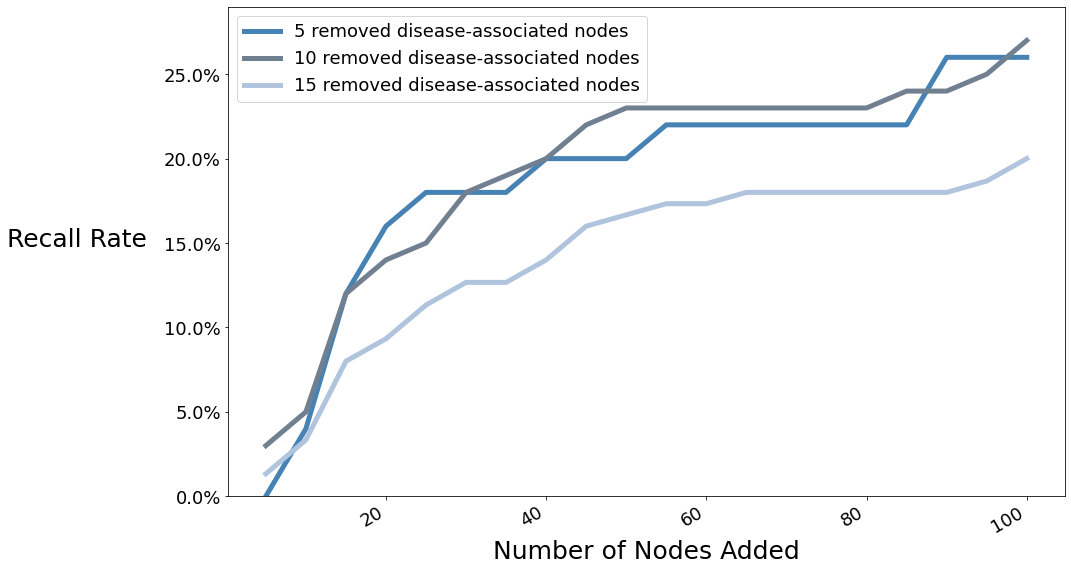

In [38]:
fig, ax = plt.subplots(figsize=(15,10))

matplotlib.rcParams['font.sans-serif'] = 'Malgun Gothic'
matplotlib.rcParams["font.family"] = 'sans-serif'

ax.plot(df_5.index, df_5['alpha = 1'], color = 'steelblue', linewidth=5)
ax.plot(df_10.index, df_10['alpha = 1'], color = 'slategrey', linewidth=5)
ax.plot(df_15.index, df_15['alpha = 1'], color = 'lightsteelblue', linewidth=5)

ax.legend(['5 removed disease-associated nodes', \
           '10 removed disease-associated nodes', \
           '15 removed disease-associated nodes'], fontsize = 18)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', which='major', labelsize=18)


ax.set_xlabel('Number of Nodes Added', fontsize=25)
ax.set_ylabel('Recall Rate', fontsize=25, rotation=0)
ax.axis(ymin = 0, ymax = 29)
ax.yaxis.set_label_coords(-0.18,0.5)

fig.autofmt_xdate()

plt.savefig('/home/compomics/Jana/DataFrames/10_Testing_DIAMOnD_PPI_Breast_Carcinoma_100.png', bbox_inches = 'tight')
plt.show()